In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from h3 import h3
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.graphics.gofplots import qqplot
import scipy as sp
import numpy as np


    To read the bike trip details

In [6]:
bike_trips_data = pd.read_excel('bike_trip_details.xlsx')

In [3]:
def get_hex_id(lat,long,res=8):
    return h3.geo_to_h3(lat,long, res)

In [4]:
def get_part_of_day(hour):
    return (
        "morning" if 5 <= hour <= 11
        else
        "afternoon" if 12 <= hour <= 17
        else
        "evening" if 18 <= hour <= 22
        else
        "night"
    )


def get_weekday(day):
    return (
        "weekday" if day < 5
        else
        "weekend" )

In [5]:
# adding extra
bike_trips_data['pick_hex_id'] = bike_trips_data.apply(lambda x: get_hex_id(x.pick_lat, x.pick_lng), axis=1)
bike_trips_data['drop_hex_id'] = bike_trips_data.apply(lambda x: get_hex_id(x.drop_lat, x.drop_lng), axis=1)
bike_trips_data['date_time']=bike_trips_data['timestamp'].apply(lambda x : datetime.fromtimestamp(x/1000))
bike_trips_data['part_of_day']=bike_trips_data['date_time'].apply(lambda x : get_part_of_day(x.hour))
bike_trips_data['weekday']=bike_trips_data['date_time'].apply(lambda x : get_weekday(x.weekday()))

In [10]:
# data-points,features, and columns
print(bike_trips_data.shape)

print(bike_trips_data.columns)


(44587, 10)
Index(['trip_id', 'customer_id', 'timestamp', 'pick_lat', 'pick_lng',
       'drop_lat', 'drop_lng', 'travel_distance', 'travel_time', 'trip_fare'],
      dtype='object')


### To look for Missing values 

    can view atleast 234 values where distance is missing and could be imputed using trip_fare and travel_time

In [460]:

bike_trips_data[(bike_trips_data.travel_distance <=0) | (bike_trips_data.travel_distance.isnull())].trip_id.count()

234

    can view atleast 234 values where distance is missing and could be imputed using trip_fare and travel_time

In [461]:
bike_trips_data = bike_trips_data[~((bike_trips_data.travel_distance <=0) | (bike_trips_data.travel_distance.isnull()))]

     No missing data in datetime

In [462]:
print(bike_trips_data.date_time.max())
print(bike_trips_data.date_time.min())

2019-01-07 23:59:25.111000
2019-01-02 00:02:07.135000


### EDA

    as you distance can see doesn't follow a guassian distribution

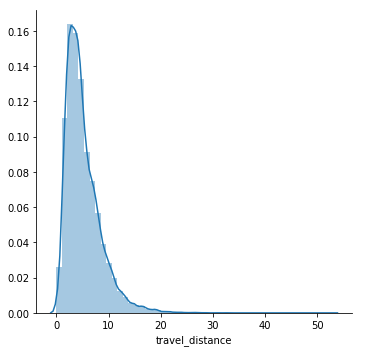

In [324]:
#drawing probablity distribution function(PDF)
sns.FacetGrid(bike_trips_data, size=5) \
   .map(sns.distplot, "travel_distance") \
   .add_legend();
plt.show();


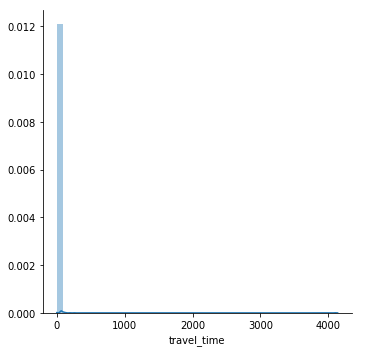

In [325]:
#drawing probablity distribution function(PDF)
sns.FacetGrid(bike_trips_data, size=5) \
   .map(sns.distplot, "travel_time") \
   .add_legend();
plt.show();

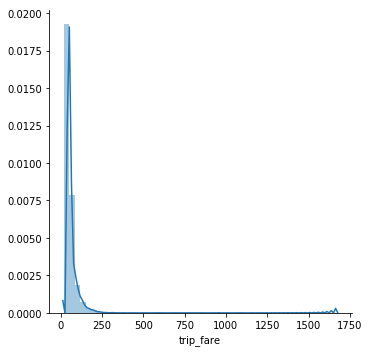

In [326]:
#drawing probablity distribution function(PDF)
sns.FacetGrid(bike_trips_data, size=5) \
   .map(sns.distplot, "trip_fare") \
   .add_legend();
plt.show();

    most rides happpen at weekday evening

In [61]:
bike_trips_data.groupby(['weekday','part_of_day'])['trip_id'].count()

weekday  part_of_day
weekday  afternoon      10399
         evening        11021
         morning        10672
         night           1040
weekend  afternoon       4236
         evening         3718
         morning         2898
         night            603
Name: trip_id, dtype: int64

    half of the rides have a travel time of 13 minutes except the weekday night,weekend night and morning which is less than usual 

In [69]:
bike_trips_data.groupby(['weekday','part_of_day'])['travel_time'].median()

weekday  part_of_day
weekday  afternoon      13.070617
         evening        13.837917
         morning        13.026325
         night          10.180367
weekend  afternoon      13.201875
         evening        13.573642
         morning        12.099100
         night          11.009133
Name: travel_time, dtype: float64

    Note: weekend night travel time is less than weekday night even when the travel distance is more traffice would be the factor that is effecting the travel time

In [71]:
bike_trips_data.groupby(['weekday','part_of_day'])['travel_distance'].median()

weekday  part_of_day
weekday  afternoon      4.1740
         evening        4.2230
         morning        4.3255
         night          4.3465
weekend  afternoon      4.3765
         evening        4.5005
         morning        4.5605
         night          4.7920
Name: travel_distance, dtype: float64

In [73]:
bike_trips_data.groupby(['weekday','part_of_day'])['trip_fare'].median()

weekday  part_of_day
weekday  afternoon      45
         evening        45
         morning        46
         night          46
weekend  afternoon      46
         evening        47
         morning        48
         night          49
Name: trip_fare, dtype: int64

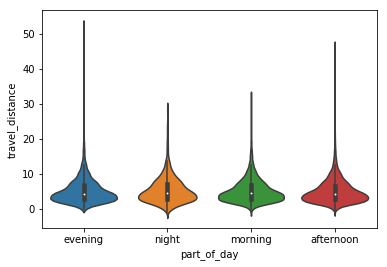

In [72]:
#voilin plot across different part of the day
sns.violinplot(x="part_of_day", y="travel_distance", data=bike_trips_data, size=8)
plt.show()

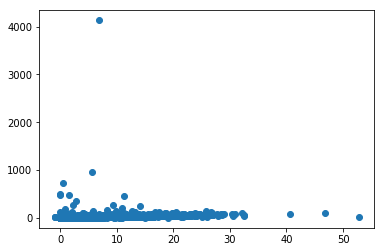

In [8]:
#scatter plot 
plt.scatter(bike_trips_data['travel_distance'], bike_trips_data['travel_time'])

In [7]:
# The pearsonr() SciPy function can be used to calculate the 
# Pearson’s correlation coefficient between two data samples with the same length.
pearsonr(bike_trips_data['travel_distance'], bike_trips_data['travel_time'])

(0.37117995463512937, 0.0)

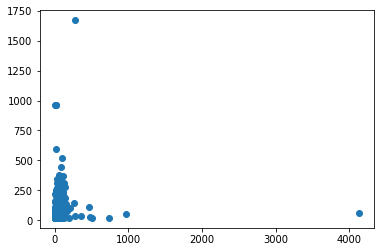

In [328]:
plt.scatter(bike_trips_data['travel_time'], bike_trips_data['trip_fare'])

In [329]:
pearsonr(bike_trips_data['travel_time'], bike_trips_data['trip_fare'])

(0.35447616503456036, 0.0)

    We can see that the travel_distance and trip_fare are positively correlated and that the correlation is 0.89

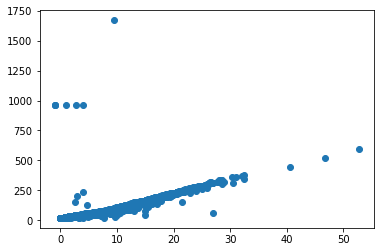

In [52]:
plt.scatter(bike_trips_data['travel_distance'], bike_trips_data['trip_fare'])

In [53]:
pearsonr(bike_trips_data['travel_distance'], bike_trips_data['trip_fare'])

(0.8893973057545692, 0.0)

### To find Anmolies and remove them

    Mahalanobis distance is an effective multivariate distance metric that measures the distance between 
    a point and a distribution.It is an extremely useful metric having, excellent applications in 
    multivariate anomaly detection 

    we use this multivariate anamoly because fare is dependent on distance and time travel.
    for example: we cant neglect higher fare value as a anamoly it is justified if it's a higher distance and time


In [7]:

def get_mahalanobis_distance(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

bike_trips_data['mahalanobis_distance'] = get_mahalanobis_distance(x=bike_trips_data[['travel_distance', 'trip_fare']], \
                                        data=bike_trips_data[['travel_distance', 'trip_fare']])

    as you can see the more the mahalanobis distance the values are tending to be anamoly 
    for example: 
    1) 1670 fare for 9 kmm is not accurate 
    2) 959 fare for 1 km is not accurate

In [476]:
df = bike_trips_data.sort_values(by=['mahalanobis_distance'],ascending=[False]).reset_index(drop=True).head(5)
print("ANAMOLIES:")
df[['travel_distance','travel_time','trip_fare','mahalanobis_distance']]

ANAMOLIES:


,travel_distance,travel_time,trip_fare,mahalanobis_distance
0,9.400,267.825483,1670,14488.762010
1,1.000,1.596217,959,5161.028499
2,2.700,10.949667,959,4995.618196
3,4.000,10.143917,959,4871.271256
4,52.801,14.164500,593,278.818409


In [478]:
anamolies = bike_trips_data[bike_trips_data.mahalanobis_distance > 100
               ].sort_values(by=['mahalanobis_distance'],ascending=[False]).reset_index(drop=True)

    all the anamolies as per the mahalanobis

In [479]:
# To remove Anamolies
bike_trips_data = bike_trips_data[~bike_trips_data.trip_id.isin(anamolies.trip_id)].reset_index(drop=True)
anamolies[['trip_id','travel_distance','travel_time','trip_fare']]

,trip_id,travel_distance,travel_time,trip_fare
0,ID42531,9.400,267.825483,1670
1,ID36240,1.000,1.596217,959
2,ID27305,2.700,10.949667,959
3,ID26723,4.000,10.143917,959
4,ID7166,52.801,14.164500,593
5,ID7047,27.000,70.498000,57
6,ID24740,4.000,103.663667,235
7,ID18260,46.747,98.218850,521
8,ID10187,3.000,10.423133,202
9,ID214,40.543,83.046817,445


In [480]:
bike_trips_data['speed'] = (bike_trips_data['travel_distance']/bike_trips_data['travel_time'])*60

In [489]:
def get_anomlies(df_in, col_name):
    """
    given the data frame removes the outlier as per quantile range 
    returns : the data frame with anamolies
    """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    print("low speed as per data is {low}".format(low=fence_low))
    print("high speed as per data is {high}".format(high=fence_high))
    
    df_out = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] >fence_high)]
    return df_out

In [491]:
anamolies = get_anomlies(bike_trips_data,'speed')

low speed as per data is 4.003057307082987
high speed as per data is 36.270911263777705


In [497]:
anamolies.shape

(1173, 17)

    as we can see 1173 values are found to be anamoly as per the data where lower fence for speed is 4
    and higher fence is 36.2 
    here speed is choosen because this parameter will not be much effected even if he takes 50 km ride or a 2 km ride
    the data has speed as low as 0.000238 kmph and high as 11878 kmph

In [498]:
anamolies[['travel_time','travel_distance','trip_fare','speed']].sort_values(by='speed').reset_index(drop=True).head(5)

,travel_time,travel_distance,trip_fare,speed
0,504.808017,0.002,20,0.000238
1,29.470933,0.001,20,0.002036
2,128.724917,0.005,20,0.002331
3,6.668383,0.001,20,0.008998
4,19.428517,0.004,20,0.012353


In [499]:
anamolies[['travel_time','travel_distance','trip_fare','speed']].sort_values(by='speed',ascending=False).reset_index(drop=True).head(5)

,travel_time,travel_distance,trip_fare,speed
0,0.075300,14.908,162,11878.884462
1,0.065133,9.419,91,8676.663699
2,0.052483,6.650,59,7602.413947
3,0.054417,6.766,58,7460.213938
4,0.054417,6.567,52,7240.795881
